### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## Helper Functions for Plotting Predictions and Calculating RMSE

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [3]:
# First, we get the data
dataset = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [4]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Visualizing the data

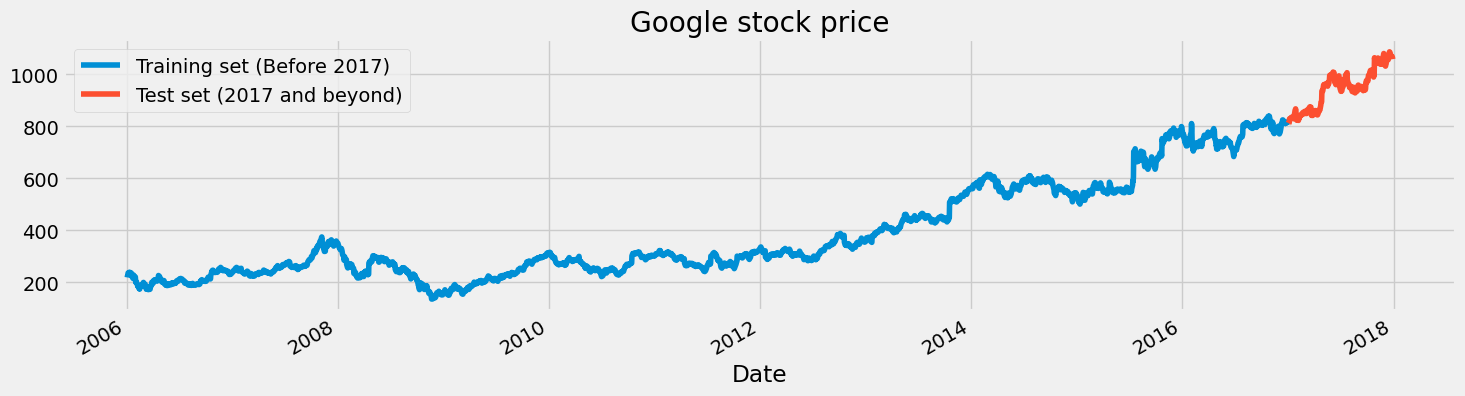

In [5]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [7]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i-1,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model

In [9]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=30,batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0274
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0086
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - loss: 0.0055
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 0.0041
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - loss: 0.0043
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 0.0036
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - loss: 0.0032
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - loss: 0.0029
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - loss: 0.0025
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss: 0.0029
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - loss: 0.0026
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 0.0022
Epoch 13/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.0021
Epoch 14/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.0026
Epoch 15/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 


## Make preductuion with LSTM model

In [10]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [11]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


Visualizing the results

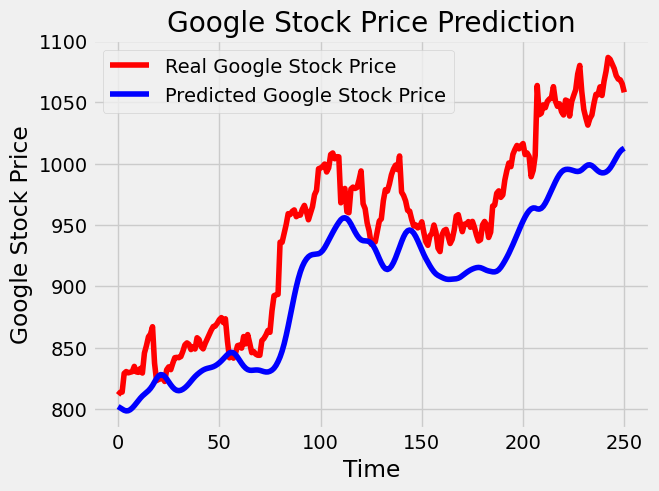

In [12]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [13]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 47.46144547276426.


## GRU Model

In [15]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)

In [17]:
regressorGRU.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [18]:
regressorGRU.fit(X_train,y_train,epochs=30,batch_size=150)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - loss: 0.1044
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.0327
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 0.0062
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - loss: 0.0040
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - loss: 0.0030
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - loss: 0.0029
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - loss: 0.0024
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - loss: 0.0024
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - loss: 0.0024
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - loss: 0.0022
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - loss: 0.0024
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - loss: 0.0023
Epoch 13/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - loss: 0.0020
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - loss: 0.0020
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/


## Make preductuion with GRU model

In [19]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step


Visualizing the Results

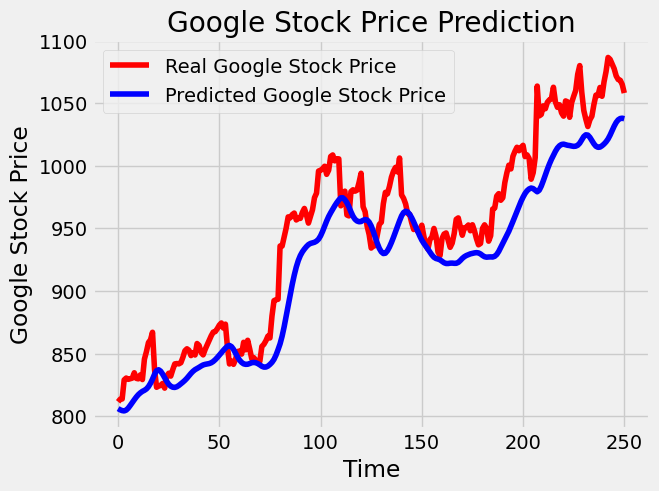

In [20]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [21]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 32.08148091492159.
